In [ ]:
# ---------------------------------------------
# PROJECT GOAL
# ---------------------------------------------
# Goal: To develop an LSTM model that predicts whether an activity in the MHEALTH dataset is risky or not,
# based on multi-sensor time-series data from a body-worn device.
# Tasks include: Preprocessing, Segmentation, LSTM modeling, and Evaluation.
# ---------------------------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, precision_score, recall_score, f1_score


In [ ]:
# Load Dataset
train_X = pd.read_csv('/content/drive/MyDrive/mhealth_raw_data.csv')
test_X = pd.read_csv('/content/drive/MyDrive/test.csv')
train_X.shape,test_X.shape

((246210, 14), (64342, 14))

In [ ]:
# 3. RISK LABEL MAPPING (Corrected and Improved)
activity_to_risk = {
    0: 0, # Nothing
    1: 0, # Standing still
    2: 0, # Sitting and relaxing
    3: 0, # Lying down
    4: 1, # Walking
    5: 1, # Climbing stairs
    6: 1, # Waist bends forward
    7: 0, # Frontal elevation of arms
    8: 1, # Knees bending (crouching)
    9: 1, # Cycling
    10:1, # Jogging
    11:1, # Running
    12:1  # Jumping front & back
}

y_train = train_X['Activity'].map(activity_to_risk)
y_test = test_X['Activity'].map(activity_to_risk)

# Then drop 'activity' and 'subject' columns from features
X_train = train_X.drop(columns=['Activity', 'subject'])
X_test = test_X.drop(columns=['Activity', 'subject'])

In [ ]:
# 4. CREATE WINDOWED DATASETS
def create_dataset(X, y, time_steps=100, step=50):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i:(i + time_steps)]
        Xs.append(x)
        ys.append(stats.mode(labels, keepdims=True)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

X_train_seq, y_train_seq = create_dataset(X_train, y_train, time_steps=100, step=50)
X_test_seq, y_test_seq = create_dataset(X_test, y_test, time_steps=100, step=50)

print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(4923, 100, 12) (4923, 1)
(1285, 100, 12) (1285, 1)


In [ ]:
# 5. BUILD LSTM MODEL (Binary Risk Classification)
model = keras.Sequential([
    layers.Input(shape=(100, X_train_seq.shape[2])),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(32),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 64)        │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,305 (134.00 KB)

 Trainable params: 34,305 (134.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 6. TRAINING SETUP
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model_risk.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7598 - loss: 0.5217

77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.7611 - loss: 0.5198 - val_accuracy: 0.8747 - val_loss: 0.3513
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 23s 199ms/step - accuracy: 0.9508 - loss: 0.1623 - val_accuracy: 0.8420 - val_loss: 0.4506
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.9664 - loss: 0.1118 - val_accuracy: 0.8521 - val_loss: 0.6946
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.9780 - loss: 0.0895 - val_accuracy: 0.8786 - val_loss: 0.4759
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9948 - loss: 0.0317 - val_accuracy: 0.8895 - val_loss: 0.5638
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9898 - loss: 0.0500

77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.9898 - loss: 0.0499 - val_accuracy: 0.9300 - val_loss: 0.3075
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9892 - loss: 0.0497 - val_accuracy: 0.8786 - val_loss: 0.6707
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9940 - loss: 0.0313 - val_accuracy: 0.8724 - val_loss: 0.6366
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.9943 - loss: 0.0334 - val_accuracy: 0.8872 - val_loss: 0.6751
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.9972 - loss: 0.0202 - val_accuracy: 0.8848 - val_loss: 0.7014
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9983 - loss: 0.0139 - val_accuracy: 0.8825 - val_loss: 0.6693
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9981 - loss: 0.0106 - val_accuracy: 0.8591 - val_loss: 0.6991
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9956 - loss: 0.0269 - val_accuracy: 0

77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.8413 - loss: 0.3983 - val_accuracy: 0.8957 - val_loss: 0.2622
Epoch 17/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8855 - loss: 0.2395

77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.8859 - loss: 0.2389 - val_accuracy: 0.9175 - val_loss: 0.1798
Epoch 18/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9591 - loss: 0.1259

77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - accuracy: 0.9591 - loss: 0.1258 - val_accuracy: 0.9082 - val_loss: 0.1785
Epoch 19/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - accuracy: 0.9780 - loss: 0.0802 - val_accuracy: 0.9198 - val_loss: 0.2023
Epoch 20/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9901 - loss: 0.0360 - val_accuracy: 0.8981 - val_loss: 0.4843
Epoch 21/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.9849 - loss: 0.0559 - val_accuracy: 0.9175 - val_loss: 0.3821
Epoch 22/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9871 - loss: 0.0466 - val_accuracy: 0.9292 - val_loss: 0.2643
Epoch 23/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9951 - loss: 0.0228 - val_accuracy: 0.9230 - val_loss: 0.3591
Epoch 24/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.9965 - loss: 0.0165 - val_accuracy: 0.9152 - val_loss: 0.3354
Epoch 25/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9950 - loss: 0.0229 - val_accuracy

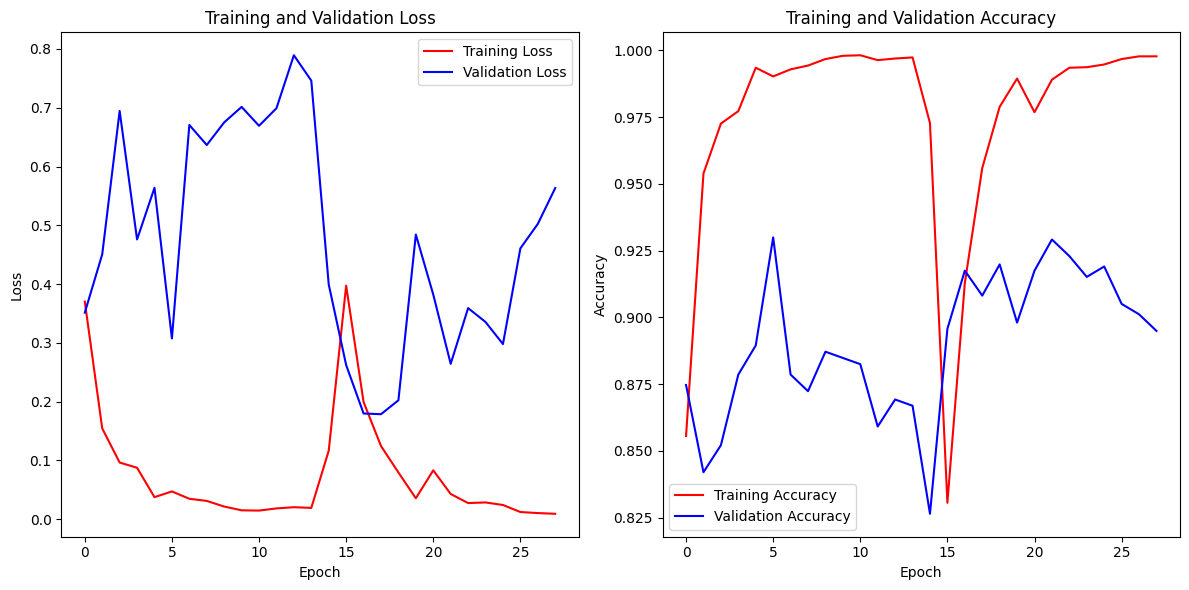

In [ ]:
# 7. PLOTTING TRAINING HISTORY
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 8. MODEL EVALUATION
model = keras.models.load_model("best_model_risk.h5")

train_loss, train_acc = model.evaluate(X_train_seq, y_train_seq)
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9796 - loss: 0.0914
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8775 - loss: 0.3511
Train Accuracy: 0.9799, Train Loss: 0.0749
Test Accuracy: 0.9082, Test Loss: 0.1785


In [ ]:
# 9. PREDICTIONS
pred_probs = model.predict(X_test_seq).flatten()
preds = (pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test_seq, preds))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       572
           1       0.89      0.96      0.92       713

    accuracy                           0.91      1285
   macro avg       0.91      0.90      0.91      1285
weighted avg       0.91      0.91      0.91      1285



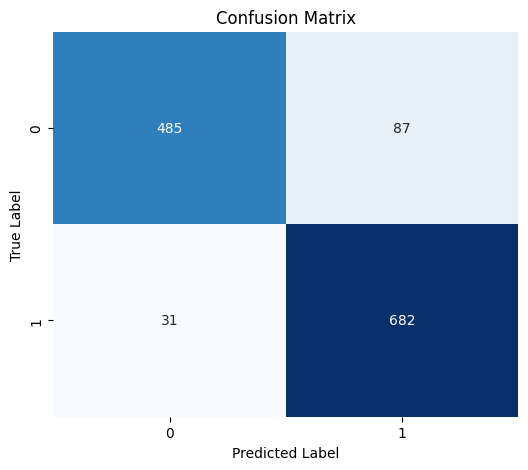

In [ ]:
# 10. CONFUSION MATRIX
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_test_seq, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


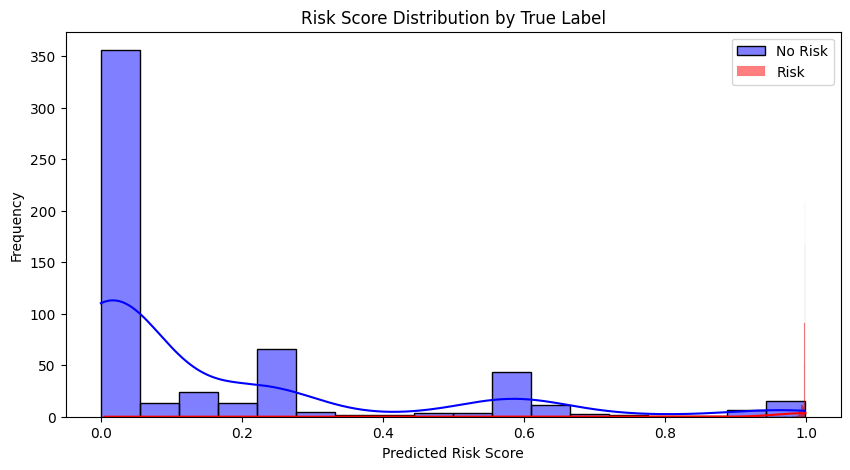

Mean Risk Score for No-Risk: 0.1630 (StdDev: 0.2521)
Mean Risk Score for Risk: 0.9585 (StdDev: 0.1437)


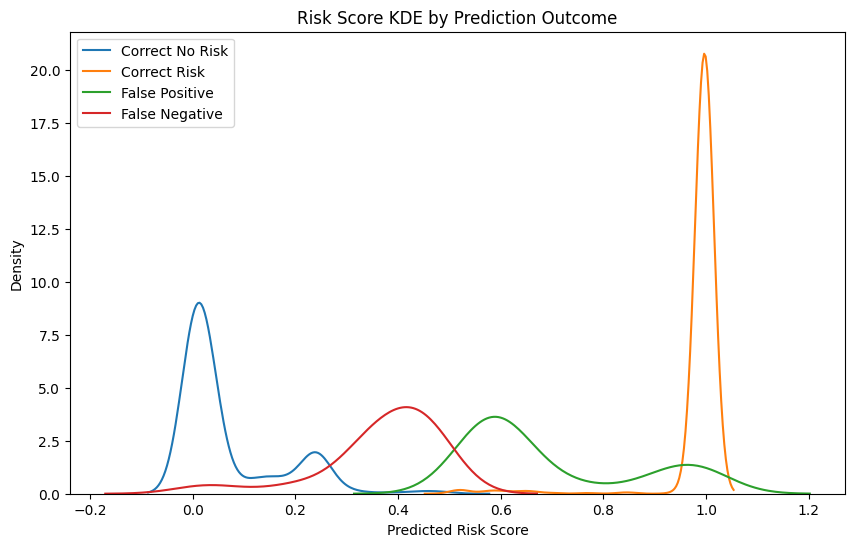

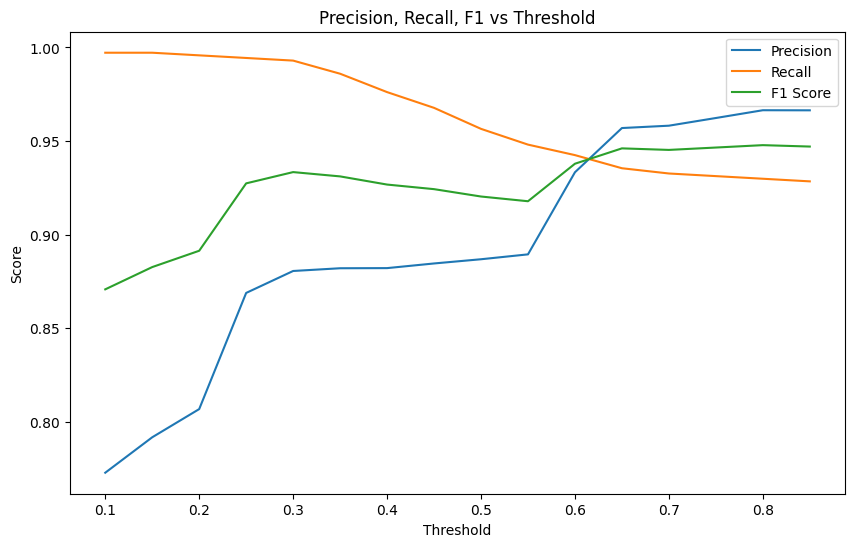

In [ ]:
# 11. DEEP RISK SCORE ANALYSIS

# Risk Score Distribution
plt.figure(figsize=(10,5))
sns.histplot(pred_probs[y_test_seq.flatten()==0], color='blue', label='No Risk', kde=True)
sns.histplot(pred_probs[y_test_seq.flatten()==1], color='red', label='Risk', kde=True)
plt.title('Risk Score Distribution by True Label')
plt.xlabel('Predicted Risk Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Mean and StdDev of Risk Scores
mean_no_risk = np.mean(pred_probs[y_test_seq.flatten()==0])
std_no_risk = np.std(pred_probs[y_test_seq.flatten()==0])
mean_risk = np.mean(pred_probs[y_test_seq.flatten()==1])
std_risk = np.std(pred_probs[y_test_seq.flatten()==1])

print(f"Mean Risk Score for No-Risk: {mean_no_risk:.4f} (StdDev: {std_no_risk:.4f})")
print(f"Mean Risk Score for Risk: {mean_risk:.4f} (StdDev: {std_risk:.4f})")

# Correct vs Incorrect Predictions KDE
correct_no_risk = (y_test_seq.flatten()==0) & (preds==0)
correct_risk = (y_test_seq.flatten()==1) & (preds==1)
false_positive = (y_test_seq.flatten()==0) & (preds==1)
false_negative = (y_test_seq.flatten()==1) & (preds==0)

groups = {'Correct No Risk': pred_probs[correct_no_risk],
          'Correct Risk': pred_probs[correct_risk],
          'False Positive': pred_probs[false_positive],
          'False Negative': pred_probs[false_negative]}

plt.figure(figsize=(10,6))
for name, scores in groups.items():
    sns.kdeplot(scores, label=name)
plt.title('Risk Score KDE by Prediction Outcome')
plt.xlabel('Predicted Risk Score')
plt.legend()
plt.show()

# Threshold Analysis
thresholds = np.arange(0.1, 0.9, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []

for thresh in thresholds:
    preds_thresh = (pred_probs > thresh).astype(int)
    precision_scores.append(precision_score(y_test_seq, preds_thresh))
    recall_scores.append(recall_score(y_test_seq, preds_thresh))
    f1_scores.append(f1_score(y_test_seq, preds_thresh))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

# END


In [ ]:
pred_probs = model.predict(X_test_seq).flatten()
preds = (pred_probs > 0.5).astype(int)


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


In [ ]:
results_df = pd.DataFrame({
    'Predicted Risk Score': pred_probs,
    'Predicted Label': preds,
    'Actual Label': y_test_seq.flatten()
})

# See first 10 predictions
print(results_df.head(10))


   Predicted Risk Score  Predicted Label  Actual Label
0              0.101306                0             0
1              0.257928                0             0
2              0.067459                0             0
3              0.149907                0             0
4              0.161925                0             0
5              0.126977                0             0
6              0.129249                0             0
7              0.209484                0             0
8              0.165283                0             0
9              0.133699                0             0


In [ ]:
index = 42  # any index from 0 to len(X_test_seq) - 1
sample = X_test_seq[index].reshape(1, 100, X_test_seq.shape[2])
true_label = y_test_seq[index][0]

# Predict
pred_score = model.predict(sample).flatten()[0]
pred_label = int(pred_score > 0.5)

print(f"Sample #{index}")
print(f"Predicted Risk Score: {pred_score:.4f}")
print(f"Predicted Label: {pred_label} (Risk)" if pred_label else "Predicted Label: 0 (No Risk)")
print(f"Actual Label: {true_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Sample #42
Predicted Risk Score: 0.1166
Predicted Label: 0 (No Risk)
Actual Label: 0


In [ ]:
errors = results_df[results_df['Predicted Label'] != results_df['Actual Label']]
print(errors.head(10))  # First 10 misclassifications


    Predicted Risk Score  Predicted Label  Actual Label
13              0.977398                1             0
14              0.649086                1             0
19              0.940189                1             0
23              0.989767                1             0
25              0.985844                1             0
26              0.914908                1             0
27              0.972131                1             0
30              0.938379                1             0
32              0.988627                1             0
37              0.988751                1             0


In [ ]:
# Most confident incorrect predictions
errors['Confidence Gap'] = abs(errors['Predicted Risk Score'] - 0.5)
errors_sorted = errors.sort_values(by='Confidence Gap', ascending=False)
print(errors_sorted.head(5))


     Predicted Risk Score  Predicted Label  Actual Label  Confidence Gap
274              0.998132                1             0        0.498132
52               0.995114                1             0        0.495114
664              0.005596                0             1        0.494404
53               0.990729                1             0        0.490729
23               0.989767                1             0        0.489767


<ipython-input-20-fea7c3f79a37>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['Confidence Gap'] = abs(errors['Predicted Risk Score'] - 0.5)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Flatten labels
y_true = y_test_seq.flatten()
y_pred = (pred_probs > 0.5).astype(int)

# Calculate metrics
accuracy  = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred) * 100
recall    = recall_score(y_true, y_pred) * 100
f1        = f1_score(y_true, y_pred) * 100
auc       = roc_auc_score(y_true, pred_probs) * 100

# Display
print(f"Accuracy : {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall   : {recall:.2f}%")
print(f"F1 Score : {f1:.2f}%")
print(f"AUC      : {auc:.2f}%")


Accuracy : 90.82%
Precision: 88.69%
Recall   : 95.65%
F1 Score : 92.04%
AUC      : 98.74%
